<h1 style="font-size:30px;">Introduction to Object Tracking</h1> 

Object tracking is an important and practical topic that has a very long history and has been applied to numerous fields. At a high level, tracking refers to estimating the state of an object (e.g., position and velocity) based on sensor measurements, and predicting its future location. For example, tracking the location of an aircraft based on radar measurements is a typical application of tracking. In the context of computer vision, tracking typically refers to processing video frames and predicting the location of an object (or multiple objects), in future video frames. 

In computer vision, this is accomplished using a motion model and an appearance model. The motion model will estimate the position and velocity of an object and use that information to predict the location of an object in future video frames and the appearance model encodes what the object looks like and then search the region around the predicted location from the motion model to then fine-tune the location of the object. So the motion model is an approximation to where the object might be located in a future video frame and the appearance model is used to fine-tune that estimate.


OpenCV contains an API Tracker Class that includes several different tracker models which are all based on different algorithms. Depending on the application one model might be better suited than another. In this notebook, we will take a look as to how each of these models performs on a sample video of a race car.

## <font style="color:rgb(50,120,229)">Tracking Objective</font>

 Given the initial location of an object in a video stream, predict it's location in subsequent frames.
 
<br>
<center>
<img src = "https://opencv.org/wp-content/uploads/2021/09/c0-m16-01-Object-Tracker-Feature-Image.png" alt="Object Tracker">
</center>
<br>

## <font style="color:rgb(50,120,229)">Tracking Models Available in the  OpenCV Tracker Class</font>

1. BOOSTING
2. CSRT
3. KCF 
4. MEDIANFLOW
5. MIL
6. MOSSE
7. TLD

In [1]:
if 'google.colab' in str(get_ipython()):
    print("Downloading Code to Colab Environment")
    !wget https://www.dropbox.com/sh/uklrcxd2d4zfcp3/AAAQiMxAHkBlQUP-6wCzTa58a?dl=1 -O module-code.zip -q --show-progress
    !unzip -qq module-code.zip
    !pip install --upgrade opencv-contrib-python
else:
    pass


In [2]:
import cv2
import sys
import os
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip

# 1. Preview Sample Video

In [ ]:
input_video = './race_car.mp4'
clip = VideoFileClip(input_video)
clip.ipython_display(width=1000)

# 2. Define Annotation Convenience Functions

In [3]:
def drawBannerText(frame, text, banner_height_percent=0.08, font_scale=.8, text_color=(0, 255, 0), 
                   font_thickness=2):
    # Draw a black filled banner across the top of the image frame.
    # percent: set the banner height as a percentage of the frame height.
    banner_height = int(banner_height_percent * frame.shape[0])
    cv2.rectangle(frame, (0, 0), (frame.shape[1], banner_height), (0, 0, 0), thickness=-1)

    # Draw text on banner.
    left_offset = 20
    location = (left_offset, int(15 + (banner_height_percent * frame.shape[0]) / 2))
    cv2.putText(frame, text, location, cv2.FONT_HERSHEY_SIMPLEX, font_scale, text_color, 
                font_thickness, cv2.LINE_AA)

def drawRectangle(frame, bbox, color=(255,0,0)):
    p1 = (int(bbox[0]), int(bbox[1]))
    p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
    cv2.rectangle(frame, p1, p2, color, 2, 1)

def displayRectangle(frame, bbox, color=(255,0,0)):
    plt.figure(figsize=(20,10))
    frameCopy = frame.copy()
    drawRectangle(frameCopy, bbox, color)
    frameCopy = cv2.cvtColor(frameCopy, cv2.COLOR_RGB2BGR)
    plt.imshow(frameCopy); plt.axis('off')

def drawText(frame, text, location=(20,20), font_scale=1, color=(50,170,50), font_thickness=2):
    cv2.putText(frame, text, location, cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, 
                font_thickness, cv2.LINE_AA)


# 3. Create a Tracker Instance

In [4]:
# Set up tracker.
tracker_types = ['BOOSTING', 'CSRT', 'KCF', 'MEDIANFLOW', 'MIL', 'MOSSE', 'TLD']

# Change the index to change the tracker type.
tracker_type = tracker_types[0] 

if tracker_type == 'BOOSTING':
    tracker = cv2.legacy.TrackerBoosting_create()
elif tracker_type == 'CSRT':
    tracker = cv2.legacy.TrackerCSRT_create()
elif tracker_type == 'KCF':
    tracker = cv2.legacy.TrackerKCF_create()
elif tracker_type == 'MEDIANFLOW':
    tracker = cv2.legacy.TrackerMedianFlow_create()  
elif tracker_type == 'MIL':
    tracker = cv2.legacy.TrackerMIL_create()
elif tracker_type == 'MOSSE':
    tracker = cv2.legacy.TrackerMOSSE_create()
elif tracker_type == 'TLD':
    tracker = cv2.legacy.TrackerTLD_create()

# 4.  Create Video Capture and Video Writer Objects

In [10]:
# Read video
video_input_file_name = "../data/raw/race_car.mp4"

# Create output file name for annotated video.
video_output_file_name = os.path.splitext(os.path.basename(video_input_file_name))[0] + "_"  + tracker_type + '.mp4'

# Create video capture object.
video_cap = cv2.VideoCapture(video_input_file_name)

# Read first frame from video.
ok, frame = video_cap.read()

# Confirm video file can be opened.
if video_cap.isOpened():
    width  = int(video_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps    = int(video_cap.get(cv2.CAP_PROP_FPS))
else:
    print('Could not open video')
    sys.exit()

fps_write = 20    # slow down video for demonstration purposes.

# Set up video writer for mp4.
fourcc = cv2.VideoWriter_fourcc(*'mp4v')

# Create video writer object.
video_out = cv2.VideoWriter( video_output_file_name, fourcc, fps_write, (width, height) )

# 5. Define the Initial Bounding Box

The initial location of the object will be identified manually in this case. Normally this would be accomplished with an object detection model to identify the object(s) to be tracked. This process is normally referred to as object acquisition or object detection.

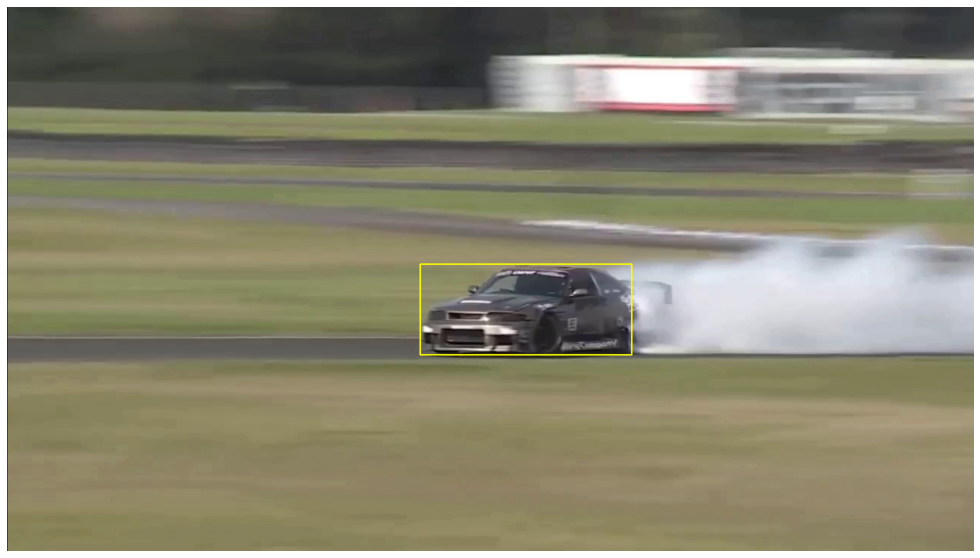

In [11]:
bbox = None
# Define a bounding box for the location of the object in the first video frame.
bbox = (820, 510, 420, 180) # race car

# Check if the a bounding box has been defined. If not, display the initial frame and alow the user to 
# manually select the bounding box with the mouse.
if bbox == None:
    # This will display the first frame of the video. Use the mouse to specify a bounding box
    # around the object to track. When done, hit the space bar or Enter key to complete the operation.
    bbox = cv2.selectROI(frame, False)  # Note: this may cause python to hang on Mac OS.
    print(bbox)

frame_copy = frame.copy()
displayRectangle(frame_copy, bbox, color=(0, 255, 255))

## <font style="color:rgb(50,120,229)">Tracking API</font>

<hr style="border:none; height: 4px; background-color:#D3D3D3" />

### <font color="green">OpenCV Documentation</font>

[**`Tracker Class`**](https://docs.opencv.org/4.5.2/d0/d0a/classcv_1_1Tracker.html)

<hr style="border:none; height: 4px; background-color:#D3D3D3" />

# 6. Intilialize Tracker 

The tracker object is initialized with a single video frame and a bounding box to identify the initial location of the object. In a more advanced application the object of interest would be detected automatically using an object detection model.

In [12]:
# Initialize the tracker with the first frame and a bounding box to identify the object of interest.
tracker.init(frame, bbox);

# 7. Processes Video Frames and Track Object

In [13]:
while True:
    ok, frame = video_cap.read()
    if not ok:
        break

    # Start timer
    timer = cv2.getTickCount()

    # Update tracker
    ok, bbox = tracker.update(frame)

    # Calculate Frames per second (FPS)
    fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer);

    # Draw bounding box
    if ok:
        drawRectangle(frame, bbox, color=(0, 255, 255))
    else:
        drawText(frame, 'Tracking failure detected', location=(80,140), color=(0, 0, 255))

    # Display Info
    drawBannerText(frame, tracker_type + ' Tracker' + ', FPS : ' + str(int(fps)))

    # Write frame to video
    video_out.write(frame)

video_cap.release()
video_out.release()

In [14]:
clip = VideoFileClip(video_output_file_name)
clip = clip.resize(height=600)
clip.ipython_display()

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [ ]:
clip = VideoFileClip('./race_car_CSRT.mp4')
clip = clip.resize(height=600)
clip.ipython_display()

In [ ]:
clip = VideoFileClip('./race_car_KCF.mp4')
clip = clip.resize(height=600)
clip.ipython_display()

In [ ]:
clip = VideoFileClip('./race_car_MEDIANFLOW.mp4')
clip = clip.resize(height=600)
clip.ipython_display()

In [ ]:
clip = VideoFileClip('./race_car_MIL.mp4')
clip = clip.resize(height=600)
clip.ipython_display()

In [ ]:
clip = VideoFileClip('./race_car_MOSSE.mp4')
clip = clip.resize(height=600)
clip.ipython_display()

In [ ]:
clip = VideoFileClip('./race_car_TLD.mp4')
clip = clip.resize(height=600)
clip.ipython_display()